In [1]:
ls

HW9.ipynb  salmon.dat


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm


# 9.4

In [3]:
df = pd.read_csv('salmon.dat',sep=' ',index_col=0)
df.head()

,recruits,spawners
year,,
1,68,56
2,77,62
3,299,445
4,220,279
5,142,138


## a

$$R=\frac{1}{\beta_1+\beta_2/S},\beta_1,\beta_2\geq0$$
也就是
$$\frac{1}{R} = \beta_1+\beta_2\frac{1}{S}$$

稳定状态$R=S$,有$$R=S=\frac{1-\beta_2}{\beta_1}$$

In [4]:
Idf = 1/df

In [5]:
# 建立线性回归模型
x = Idf.spawners.to_numpy()
y = Idf.recruits.to_numpy()
X = sm.add_constant(x)
model = sm.OLS(y,X).fit()

In [6]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3687.
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           1.89e-39
Time:                        23:33:48   Log-Likelihood:                 264.18
No. Observations:                  40   AIC:                            -524.4
Df Residuals:                      38   BIC:                            -521.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020   8.22e-05     24.502      0.000       0.002       0.002
x1             0.6978      0.011     60.721      0.000       0.675       0.721
==============================================================================
Omnibus:                        1.265   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                1.256
Skew:                           0.344   Prob(JB):                        0.534
Kurtosis:                       2.471   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# 参数估计
model.params

array([0.00201323, 0.69781884])

In [25]:
# 稳定状态
R = (1-model.params[1])/model.params[0]
R

150.0976343009784

拟合结果为
$$\frac{1}{R} = 0.002 +0.6978\frac{1}{S}$$

稳定状态$$R=S=\frac{1-0.6978}{0.002}\approx 150$$

### Bootstrap residual

In [32]:
def residual_bt(B=10000):
    R_l = []
    for i in range(B):
        y_bt = model.fittedvalues + np.random.choice(model.resid, size=40)
        model_bt = sm.OLS(y_bt, X).fit()
        R_bt = (1-model_bt.params[1])/model_bt.params[0]
        R_l.append(R_bt)
    return np.array(R_l)

In [34]:
R_l_residual = residual_bt()

In [35]:
# 95%置信区间
(np.quantile(R_l_residual,0.025),np.quantile(R_l_residual,0.975))

(142.51217735177934, 158.17483257430226)

In [36]:
# 区间长度
abs(np.quantile(R_l_residual,0.025)-np.quantile(R_l_residual,0.975))

15.662655222522915

In [39]:
# 标准误
R_l_residual.std()

4.0099787297018565

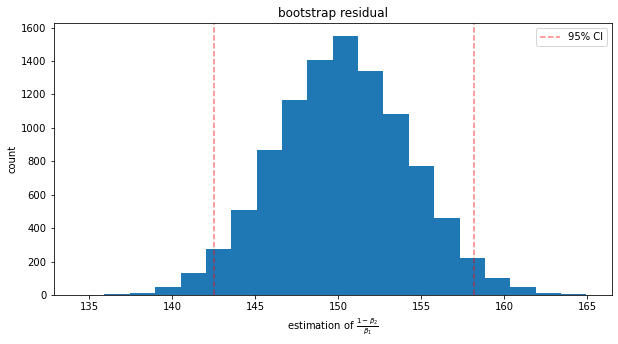

In [38]:
# 直方图
pd.DataFrame(R_l_residual).hist(grid=False, bins=20, figsize=(10, 5))
plt.title('bootstrap residual')
plt.xlabel(r'estimation of $\frac{1-\beta_2}{\beta_1}$')
plt.ylabel('count')
plt.axvline(x=np.quantile(R_l_residual, 0.025),
            color='red',
            alpha=.5,
            linestyle='dashed',
            label='95% CI')
plt.axvline(x=np.quantile(R_l_residual, 0.975),
            color='red',
            alpha=.5,
            linestyle='dashed')
plt.legend()
plt.show()

### Paired bootstrap

In [41]:
def paired_bt(B=10000):
    R_l = []
    for i in range(B):
        df_bt = Idf.loc[np.random.choice(df.index, size=40), :]
        x_bt = df_bt.spawners.to_numpy()
        y_bt = df_bt.recruits.to_numpy()
        X_bt = sm.add_constant(x_bt)
        model_bt = sm.OLS(y_bt, X_bt).fit()
        R_bt = (1 - model_bt.params[1]) / model_bt.params[0]
        R_l.append(R_bt)
    return np.array(R_l)

In [42]:
R_l_paired = paired_bt()

In [44]:
# 95%置信区间
(np.quantile(R_l_paired,0.025),np.quantile(R_l_paired,0.975))

(142.71043190209588, 157.74255035186982)

In [45]:
# 区间长度
abs(np.quantile(R_l_paired,0.025)-np.quantile(R_l_paired,0.975))

15.032118449773947

In [46]:
# 标准误
R_l_paired.std()

3.850719401715517

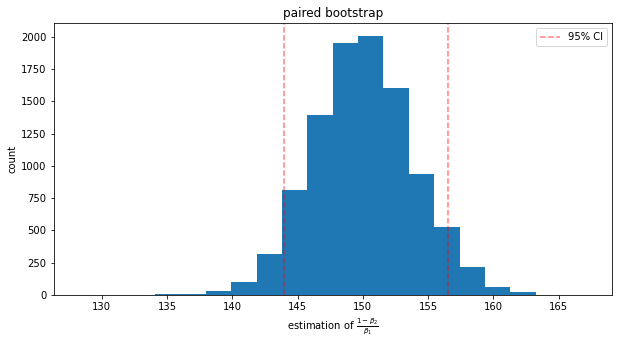

In [47]:
# 直方图
pd.DataFrame(R_l_paired).hist(grid=False, bins=20, figsize=(10, 5))
plt.title('paired bootstrap')
plt.xlabel(r'estimation of $\frac{1-\beta_2}{\beta_1}$')
plt.ylabel('count')
plt.axvline(x=np.quantile(R_l_paired, 0.05),
            color='red',
            alpha=.5,
            linestyle='dashed',
            label='95% CI')
plt.axvline(x=np.quantile(R_l_paired, 0.95),
            color='red',
            alpha=.5,
            linestyle='dashed')
plt.legend()
plt.show()

## b

In [54]:
correction_residual = np.mean(R_l_residual)-R
correction_residual

0.03710473871925046

In [55]:
correction_paired = np.mean(R_l_paired)-R
correction_paired

0.0009245873471854793

In [56]:
B = 1000
correction_residual_l = []
correction_paired_l = []
for i in range(B):
    R_l_residual = residual_bt(1000)
    R_l_paired = paired_bt(1000)
    correction_residual = np.mean(R_l_residual)-R
    correction_paired = np.mean(R_l_paired)-R
    correction_residual_l.append(correction_residual)
    correction_paired_l.append(correction_residual)

KeyboardInterrupt: 

In [ ]:
np.std(correction_residual_l)

In [ ]:
np.std(correction_paired_l)

# 9.7